# ---------------------------------------------------------------------------------------------

## EA App Text Modeling 

### This python code constructs the Text Classification model, using BERT and LDA.                                
# ---------------------------------------------------------------------------------------------

In [1]:
# pwd

In [1]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
import joblib
import re
import string

In [3]:
import numpy as np
import pandas as pd

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB

In [5]:
# pip install wordcloud
import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')
import re
import contractions

In [6]:
# pip install bertopic --user
# If you want to install BERTopic with other embedding models, you can choose one of the following:
# pip install bertopic[flair]
# pip install bertopic[gensim]
# pip install bertopic[spacy]
# pip install bertopic[use]

In [47]:
# Update the month
month = 'Nov'

## Loading the training/testing csv

In [6]:
# df = pd.read_csv(r"C:\Users\bshakeri\DnA - Tasks\EA APP Survey\EA App Feedback Survey_20221101_MLTraining.csv", encoding= 'utf-8-sig')
date = '20230301'
# directory = 'C:\Users\bshakeri\DnA - Tasks\EA APP Survey\input\'
# filename = "EA App Feedback Survey_"
df = pd.read_csv(r"C:\Users\bshakeri\DnA - Tasks\EA APP Survey\input\EA App Feedback Survey_{}.csv".format(date),
                 encoding= 'utf-8-sig')


C:\Users\bshakeri\AppData\Local\Temp\2\ipykernel_15012\2333001472.py:5: DtypeWarning: Columns (8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\bshakeri\DnA - Tasks\EA APP Survey\input\EA App Feedback Survey_{}.csv".format(date),


In [132]:
# df1 = pd.read_csv(r"C:\Users\bshakeri\DnA - Tasks\EA APP Survey\input\EA App Feedback Survey_20221101.csv", encoding= 'utf-8-sig')
# df2 = pd.read_csv(r"C:\Users\bshakeri\DnA - Tasks\EA APP Survey\input\EA App Feedback Survey_20230101.csv", encoding= 'utf-8-sig')
# df3 = pd.read_csv(r"C:\Users\bshakeri\DnA - Tasks\EA APP Survey\input\EA App Feedback Survey_20230201.csv", encoding= 'utf-8-sig')

# df = pd.concat([df1, df2, df3])
# df.head(1)

In [7]:
# Remove short comments
df = df.loc[(df["Q11D"].str.len() > 3) & (df["Q11D"].str.len() < 3000)]     # There are meaningful 4-letter words (like game names, slow, poor)
print('# Number of comments after droping values less than 3 character: {}'.format(df["Q11D"].count()))
# df.to_csv('check_df.csv', index=False,encoding= 'utf-8-sig')

# Number of comments after droping values less than 3 character: 5638


In [8]:
# data2 = df["Q11D"].dropna(axis=0)
data2 = df[df["Q11D"].notna()]
data2.shape

(5638, 187)

## EDA for the Category variable

## Clean the user input text

In [9]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
stop_words = set(STOPWORDS) # Since this survey is for commenting on errors, the sentiment is negative!
stop_words = list(stop_words)
# print(stop_words)

unwanted = {'nor', 'cannot',"doesn't", 'not' ,'no', "isn't", "hadn't","wouldn't","shan't", "shouldn't", "didn't", "mustn't",
              "wasn't","hasn't", "won't", "couldn't", "haven't", "weren't", "can't", "don't"}
stop_words = [e for e in stop_words if e not in unwanted]

# I extended the stop words to remove the swear words! 
stop_words.extend(['application','ea app','ea_app','ea', 'app','fuck', 'fucker', 'fckng', 'fucking', 'rubbish', 'shit', 'asshole', 'sucks', 'sucker', 'ass',
                   'bitches', 'bitch', 'merde', 'idiot', 'stupid', 'garbage', 'trash', 'app',
                  'dumbass'])

# print(stop_words)

def process_text(text):
    text = str(text).lower()
    text = contractions.fix(text)
    # print(text)
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )
    
    text = " ".join(text.split())
    
    return text

def process_text2(dataset):
    filtered_text = []
    final_text = []
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    tokenizer = TreebankWordTokenizer()
    
    tokens = tokenizer.tokenize(dataset)
    a1_=[]
    for w in tokens:
        if w not in stop_words:
            # lw = lemmatizer.lemmatize(w)
            # slw = stemmer.stem(w)
            a1_.append(w)
        else:                
            pass
            
    filtered_text = " ".join(a1_)

    return filtered_text 

In [10]:
# data2["clean_text"] = data2.text.map(process_text)
data2["clean_text"] = data2.Q11D.map(process_text)
data2 = data2.loc[data2['clean_text'].str.len()>0]
data2.shape

(5634, 188)

In [11]:
data2["clean_text_new"] = data2.clean_text.map(process_text2)
# data3["len_clean_text_new"] = data3['clean_text_new'].str.len()
data2 = data2.loc[data2['clean_text_new'].str.len()> 0]   
data2.shape

(5560, 189)

In [12]:
data2[["Q11D", "clean_text","clean_text_new"]].head(5)

,Q11D,clean_text,clean_text_new
0,I was in app of coarse really??? Downloading...,i was in app of coarse really downloading an a...,coarse really downloading add sims 3
1,It's not even letting me get to put in my logi...,it is not even letting me get to put in my log...,not even letting put login info
2,went to launch dragon age origins ultimate edi...,went to launch dragon age origins ultimate edi...,went launch dragon age origins ultimate editio...
3,Game was installed under Origin. Had no choice...,game was installed under origin had no choice ...,game installed origin no choice update logged ...
5,trying to play a game I hadn't in a while. sud...,trying to play a game i had not in a while sud...,trying play game not suddenly something went w...


In [13]:
data2[["Q11D"]].shape

(5560, 1)

In [14]:
# data = pd.DataFrame(data2["clean_text"])
data = pd.DataFrame(data2["clean_text_new"])
# print(data.head(2))

rows,columns=data2.shape

list_text=[] #your empty list 
for index in range(rows): #iteration over the dataframe
    list_text.append(data.iat[index,0])
    
# print(list_text)   This is a list!

In [15]:
# print(list_text) 

#### Unifying the text using symonym list

In [16]:
synonyms = pd.read_csv(r"C:\Users\bshakeri\DnA - Tasks\EA APP Survey\lists\synonym_list.csv")
# synonyms.tail(1)

# Set to dictionary
synonym_dict = synonyms.set_index('SYNONYM')['NAME'].to_dict()

processed = []
def multiple_replace(text, word_dict):
# create a regular expression pattern from the dictionary keys
  pattern = re.compile("|".join(map(re.escape, word_dict.keys())))
  
  for i in text:
        a = pattern.sub(lambda x: word_dict[x.group(0)], i)
        processed.append(a)
  # use re.sub to replace the keys with values in the text
  return processed

#replace the words in the text using the dictionary
#result = multiple_replace(text, word_dict)
final_text = multiple_replace(list_text, synonym_dict)

# print("String after multiple replace : " + str(result))

In [17]:
print(final_text[2896])

try play game


In [18]:
again_df = pd.DataFrame(final_text, columns=['body'])
again_df.head(10)

,body
0,coarse really download add sims 3
1,not even letting put login info
2,went launch dragon_age origins ultimate editio...
3,game install origin no choice update logged we...
4,try play game not suddenly something went wron...
5,not anything says error end beta forcing use b...
6,trouble updating game initially switched origi...
7,click
8,handicapped
9,not receive invite not send


##### Here it might be useful to have a cloud word?

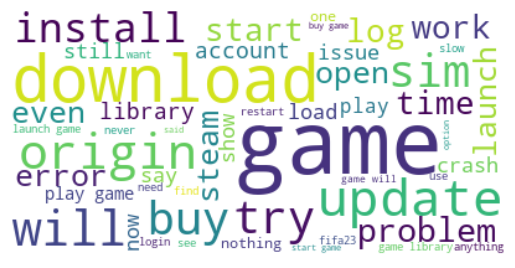

In [145]:
# There are three types of tokenizer
# WhitespaceTokenizer()
# TreebankWorkTokenizer()
# WordPunctTokenizer()

final_text_cloud = " ".join(cat for cat in final_text)

tokenizer = nltk.tokenize.TreebankWordTokenizer()

tokens = tokenizer.tokenize(final_text_cloud)
# print(tokens)
final_text_cloud = " ".join(t for t in tokens)

# print(final_text_cloud[3])

# # Create and generate a word cloud image:
wordcloud = WordCloud().generate(final_text_cloud)

# Display the generated image:
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="white").generate(final_text_cloud)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Sentiment Analysis

In [146]:
#def Sentiment_Reddit():
    
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
# import pypyodbc

#     conn = pypyodbc.connect('dsn=Banshee+prod',autocommit=True)
#     sql_query= """
#     SELECT link, body, timestamp
#     FROM banshee-index
#     WHERE feed_id = "135"
#     ORDER BY timestamp DESC
#     LIMIT 10000
#     """

#     dataset=pd.read_sql(sql_query,conn)
    
#     # Preprocess text (username and link placeholders)
#     def preprocess(text):
#         new_text = []
#         for t in text.split(" "):
#             t = '@user' if t.startswith('@') and len(t) > 1 else t
#             t = 'http' if t.startswith('http') else t
#             new_text.append(t)
#         return " ".join(new_text)


MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)

# df = pd.DataFrame(dataset, columns=["body","timestamp"])
# df = df.astype(str)
# text = df['body'].apply(lambda x: preprocess(x))
# print(text)

def predict_sentiment(text):
    encoded_input = tokenizer([text], padding=True, truncation=True,
                              max_length=50, add_special_tokens = True,return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

again_df['Scores'] = again_df['body'].apply(lambda x: predict_sentiment(x))
again_df['Scores'] = again_df['Scores'].apply(lambda x: np.argsort(x))
again_df['Index']= again_df['Scores'].apply(lambda x: np.where(x==2))

# df.to_csv(r'\\eaie-filer2.ad.ea.com\eaie_qa\MT_ProjectEchoes\CSV_Files\Sentiment_Reddit.csv',mode='w+', index=False)
  

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [147]:
# The order of the index is: [negative,neutral,positive] 
# 2 has the highest ranking. Where 2 is located? 
# in the example of [2,1,0] the comment is negative.

In [148]:
again_df.head()

,body,Scores,Index
0,coarse really download add sims 3,"[0, 2, 1]","([1],)"
1,not even letting put login info,"[2, 1, 0]","([0],)"
2,went launch dragon_age origins ultimate editio...,"[0, 2, 1]","([1],)"
3,game install origin no choice update logged we...,"[2, 1, 0]","([0],)"
4,try play game not suddenly something went wron...,"[2, 1, 0]","([0],)"


In [149]:
# again_df.loc[again_df['body']=='game'].head(5)

In [150]:
# again_df.dtypes

In [151]:
# again_df.loc[again_df['Index']==[0,1,2]].head(5) not working

In [152]:
# again_df.loc[again_df['Scores'][0]==2].head(5) not working

In [153]:
comments = data2["Q11D"].reset_index()
# comments.to_csv('comments.csv')
comments.shape

result_sentiment = pd.concat([comments, again_df], axis=1)


In [154]:
result_sentiment.to_csv(r'C:\Users\bshakeri\DnA - Tasks\EA APP Survey\results\get_Sentiments_{date}.csv'.format(date=date), 
    index=False, encoding= 'utf-8-sig'
)

## Text Modeling using BERT 
##### Semantic representation of data is important
###### Notes: in the case of BERTopic many different variants can be tested, such as which pretrained model to implement for embeddings, what dimension reduction and clustering techniques to use.

In [155]:
# In chize khubiye

# https://github.com/mcelikkaya/medium_articles2/blob/main/bertlda_topic_modeling.ipynb
    

In [156]:


# in the case of BERTopic many different variants can be tested, 
# such as which pretrained model to implement for embeddings, 
# what dimension 
# reduction and clustering techniques to use.

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer


nr_topics=5
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Dimension reduction
# Initiate UMAP
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=10)


hdbscan_model = HDBSCAN(min_cluster_size=15, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True)



vectorizer_model = CountVectorizer(stop_words="english")

ctfidf_model = ClassTfidfTransformer()

topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  ##diversity=0.5,
  nr_topics=10                        # Step 6 - Diversify topic words
)
    
# Initiate BERTopic
## Having 8 groups is the most distinct grouping 

# topic_model = BERTopic(
#                         embedding_model=embedding_model, 
#                         umap_model=umap_model, 
#                         language="english", 
#                         calculate_probabilities=True, 
#                         nr_topics=nr_topics)


# Run BERTopic model
## topics, probabilities = topic_model.fit_transform(df["Q11D"])
# topics, probabilities = topic_model.fit_transform(list_text)
topics, probabilities = topic_model.fit_transform(final_text)


In [157]:
# -1 refers to all outliers and should typically be ignored.
topic_model.get_topic_info() #.head(10)

,Topic,Count,Name
0,-1,1286,-1_game_play_library_download
1,0,2961,0_game_sims_try_download
2,1,282,1_buy_coins_gold_payment
3,2,249,2_origin_game_install_language
4,3,210,3_steam_battlefield_battlefield2042_game
5,4,194,4_previous_comment_gone_remember
6,5,192,5_fifa23_anticheat_fifa_game
7,6,144,6_slow_speed_download_lag
8,7,26,7_clost_closts_clostd_game
9,8,16,8_error404_matrix_error_occurred


In [159]:
# date = '3 Month'
info = topic_model.get_topic_info()
info.to_csv(
    r'C:\Users\bshakeri\DnA - Tasks\EA APP Survey\results\raws\get_topics_{}.csv'.format(date), 
    index=False, encoding= 'utf-8-sig'
)

In [160]:
topic_model.get_topic(2)

[('origin', 0.23503866360555803),
 ('game', 0.07507446172257266),
 ('install', 0.05264959995154973),
 ('language', 0.051797311253845055),
 ('launch', 0.0326610327400465),
 ('used', 0.03011874223025279),
 ('download', 0.028359516323753175),
 ('forced', 0.028235916732444494),
 ('play', 0.027716293139449448),
 ('russian', 0.02472676645764687)]

In [161]:
comments = data2["Q11D"].reset_index()
# comments.to_csv('comments.csv')
comments.shape

(5560, 2)

In [162]:
docs = topic_model.get_document_info(final_text)
docs.shape

result = pd.concat([comments, docs], axis=1)
result.shape
result = result.rename({'Q11D':'Comment'})
result['Date'] = date

result.to_csv(r'C:\Users\bshakeri\DnA - Tasks\EA APP Survey\results\raws\get_docs_{date}.csv'.format(date=date), 
    index=False, encoding= 'utf-8-sig'
)

topic_model.get_document_info(final_text).head(3)

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,coarse really download add sims 3,0,0_game_sims_try_download,game - sims - try - download - launch - error ...,0.944702,False
1,not even letting put login info,0,0_game_sims_try_download,game - sims - try - download - launch - error ...,0.627164,False
2,went launch dragon_age origins ultimate editio...,0,0_game_sims_try_download,game - sims - try - download - launch - error ...,1.000000,False


In [163]:
topic_model.visualize_topics()

In [164]:
topic_model.visualize_hierarchy()

In [165]:
topic_model.visualize_barchart()

In [276]:
topic_model.visualize_heatmap()

In [149]:
topic_model.visualize_term_rank()

In [166]:
import pandas as pd

#read the csv file into a dataframe
df = pd.read_csv(r'C:\Users\bshakeri\DnA - Tasks\EA APP Survey\results\Final_docs.csv')
# Keep a backup of the last month version
# df.to_csv(r'C:\Users\bshakeri\DnA - Tasks\EA APP Survey\results\Final_docs_.csv', index=False, encoding='utf-8-sig')
result = pd.read_csv(r'C:\Users\bshakeri\DnA - Tasks\EA APP Survey\results\raws\get_docs_{}.csv'.format(date))

final = pd.concat([result, df])


# In[44]:


# QA to check the dfs have been appended correctly. 
n =  len(df) + len(result)
m = len(final)

if m == n:
    final.to_csv(r'C:\Users\bshakeri\DnA - Tasks\EA APP Survey\results\Final_docs.csv', index=False, encoding='utf-8-sig')
    print('The file has been appended successfully!')
    
else:
    print('Something went wrong!')


The file has been appended successfully!


In [30]:
# ## Install libraries
# ! python -m pip install --upgrade pip --quiet
# ! pip install spacy --quiet
# ! pip3 install spacy-transformers --quiet
# ! python -m spacy download en_trf_bertbaseuncased_lg --quiet

# #Load bert model
# nlp = en_trf_bertbaseuncased_lg.load()

# # Utility function for generating sentence embedding from the text
# def get_embeddinngs(text):
#     return nlp(text).vector

# # Generating sentence embedding from the text
# again_df['emb'] = again_df['body'].apply(get_embeddinngs)
# again_df.head()


## Import libraries
from nltk.cluster import KMeansClusterer
# import nltk

# def clustering_question(data,NUM_CLUSTERS = 15):

#     sentences = data['text']

#     X = np.array(data['emb'].tolist())

#     kclusterer = KMeansClusterer(
#         NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
#         repeats=25,avoid_empty_clusters=True)

#     assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

#     data['cluster'] = pd.Series(assigned_clusters, index=data.index)
#     data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])

#     return data, assigned_clusters

# def distance_from_centroid(row):
#     # type of emb and centroid is different, hence using tolist below
#     return distance_matrix([row['emb']], [row['centroid'].tolist()])[0][0]

# # Compute centroid distance to the data
# data['distance_from_centroid'] = data.apply(distance_from_centroid, axis=1)


## LDA Modeling

In [ ]:
#This file uses Latent Dirichlet Allocation (LDA), an algorithm for topic modeling


#Advanced natual language processing library
import spacy

#regular expressions library
import re

# Pretty Print library
from pprint import pprint

#Topic modelling and natural language processing library
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#plotting tools to aid visualisation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


import matplotlib.colors as mcolors

#delete deprecation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)




    #Now we can clean the data

    #Removing symbols(anything that is not a letter or number) from reddit comments
    data['body_Cleaned'] = data.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+"," ", str(row['body']))),axis=1)

    # Tokenization 
    data['body_Cleaned']= data.apply(lambda row: (word_tokenize(str(row['body_Cleaned']))), axis = 1)

    # Running the Stopwords
    #add in your own words to the list like "though"
    #stoplist = stopwords.words('english') + ['though']
    stopwords = stopwords.words("english")
    stop_words = set(stopwords)
    data['data_Cleaned'] = data.apply(lambda row:([w for w in row['body_Cleaned'] if w not in stop_words]),axis=1)

    # Lemmatization
    lementize = WordNetLemmatizer()
    df2 = data.apply(lambda row: ([lementize.lemmatize(w) for w in row['body_Cleaned']]), axis=1)

import csv
bigram = gensim.models.Phrases(df2,
                                min_count=5, #This defines the minimum time the words needs to occur to be considered as bigram
                                threshold=1000) # The higher threshold fewer phrases.

trigram = gensim.models.Phrases(bigram[df2], threshold=100)

# Creating an object 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# defining the functions stopwords, bigrams and trigrams
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

nlp = spacy.load("en_core_web_sm")
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Removing of Stop Words
# data_words_nostops = remove_stopwords(df2)

# Forming of trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# disable parser and ner because don't need them and it runs alot quicker
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Creating Dictionary and Corpus

    dictionary = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    #create a bag of words that contains unique words and their frequency in the corpus
    corpus = [dictionary.doc2bow(text) for text in data_lemmatized]

    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=5, #Identifies the 10 topic trends for bf2042
                                               random_state=100,
                                               update_every=1,#update the topic model after each iteration
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

    #Analysis the data 
    doc_lda = lda_model[corpus]

    pprint(lda_model.show_topics(formatted=False))

    # Compute Perplexity
    print('The Perplexity Score is : ', lda_model.log_perplexity(corpus))  # This measures of how good the model is. The lower the better.

    # Compute Coherence Score
    #coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=corpora.Dictionary(data_lemmatized), coherence='c_v')
    #coherence_lda = coherence_model_lda.get_coherence()
    #print('The Coherence Score is : ', coherence_lda)


    vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                         corpus, 
                                         dictionary, 
                                         mds="mmds", 
                                         R=20) #This choses the number of word a topic should contain.
    vis
    pyLDAvis.save_html(vis, 'LDA_Visualization.html')

    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.colors as mcolors



    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      prefer_horizontal=1,
                      height=330,
                      max_words=20,
                      colormap='flag',
                      collocations=True)
    #cloud.to_csv(r"C:\Users\mtully\OneDrive - Electronic Arts\Machine Learning Aspect-Based Analysis\cloud.csv", index=False)
    topics = lda_model.show_topics(formatted=False)
    file = open('CSV_Files\Topics.csv', 'w')

    writer = csv.writer(file)

    writer.writerow(topics)

    file.close()


    """fig, axes = plt.subplots(5, 1, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        plt.imshow(cloud.fit_words(dict(lda_model.show_topic(i, 200))))
        plt.gca().set_title('Topic' + str(i))
        plt.gca().axis('off')
    print(cloud.words_.keys())
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.suptitle("The Top 5 Topic Trend for BF2042", 
                 y=1.05,
                 fontsize=18,
                 fontweight='bold'
                 )
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()"""